<a href="https://colab.research.google.com/github/DavidF2714/TC3006B/blob/main/Actividad3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p> <img src=https://cdn-3.expansion.mx/dims4/default/bed6721/2147483647/strip/true/crop/664x400+0+0/resize/780x470!/format/webp/quality/60/?url=https%3A%2F%2Fcdn-3.expansion.mx%2Fmedia%2F2014%2F08%2F11%2Funi6.jpg width=500 height=300>
<p>

# Actividad 3
### Alumno: David Flores Becerril
### Matrícula: A01368391
### Inteligencia artificial avanzada para la ciencia de datos I
### Profesor: Esteban Castillo Juarez
### Grupo 101


## ¿Naive Bayes?

Naive Bayes es un algoritmo de clasificación basado en el teorema de Bayes, que asume que todas las características o variables predictoras son independientes entre sí (de ahí el término "naive", que significa "ingenuo"). A pesar de esta suposición simplista, el algoritmo puede ser muy efectivo para problemas de clasificación, especialmente cuando se trabaja con grandes conjuntos de datos.

Naive Bayes calcula la probabilidad posterior de cada clase dado un conjunto de características de entrada y asigna la clase con la mayor probabilidad posterior. Es particularmente útil en aplicaciones de procesamiento de lenguaje natural, como la clasificación de correos electrónicos como spam o no spam, debido a su eficiencia y simplicidad.

Para esta actividad, se decidió probar este algoritmo de aprendizaje máquina para clasificar textos(datos) provenientes de la red social "X". El objetivo de este proyecto es identifcar la precisión de clasificación del algoritmo, mediante un análisis de sentimientos a los datos mencionados anteriormente.


## Experimentación

Para la realización de este proyecto, se utilizan librerias para el manejo de datos, operaciones matemáticas, visualización gráfica y la libreria de scikit learn para analizar el modelo con herramientas optimizadas.

In [1]:
import codecs
import math
import operator
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, KFold
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se definen las variables con las que va a trabajar el modelo, además de utilizar la liberira de codecs y operator para extrar la información de los .txt que contienen los datos de entrenamiento. Apartir de los datos extraidos, se crea un vocabulario que contendra las palabras más recurrentes.

In [2]:
base_path = "/content/drive/My Drive/Colab Notebooks/TC3006B/"

# List of feature numbers to test
feature_numbers = [20, 40, 60, 80, 100, 120, 240, 480, 500]

# List of k values to test
k_values = [3, 4, 5, 6]

# Create a dictionary to store the vocabulary
vocabulary = {}

# Open file and extract tokens to build the vocabulary
with codecs.open(base_path + "training3.txt", "r", "UTF-8") as file:
    for line in file:
        elements = line.split("@@@")
        for token in elements[0].split(" "):
            if token in vocabulary:
                vocabulary[token] += 1
            else:
                vocabulary[token] = 1

# Remove empty token
if "" in vocabulary:
    del vocabulary[""]

# Sort vocabulary by frequency in descending order
sortedVocabulary = sorted(vocabulary.items(), key=operator.itemgetter(1), reverse=True)

# Save vocabulary to a file
with codecs.open(base_path + "vocabulary.txt", "w", "UTF-8") as file:
    for token in sortedVocabulary:
        file.write(token[0] + "," + str(token[1]) + "\n")


Con el vocabulario ya creado, se proceden a crear los vectores que convertiran los datos de entranamiento a un formato entendible para la máquina: Bag of Words. Este enfoque permite a la máquina analizar cada fila de los datos de entramiento y a partir del vocabulario, crear vectores que indican el número de veces que una característica aparece en la fila.

In [3]:
# Function to prepare data for a given number of features
def prepare_data(featureNumber):
    features = []
    trainingVectors = []
    trainingLabels = []
    testVectors = []
    testLabels = []

    # Extract the top 'featureNumber' tokens from the vocabulary
    with codecs.open(base_path + "vocabulary.txt", "r", "UTF-8") as file:
        count = 0
        for line in file:
            elements = line.split(",")
            if count == featureNumber:
                break
            features.append(elements[0].replace("\n", ""))
            count += 1

    # Open training data to transform it into vectors
    with codecs.open(base_path + "training3.txt", "r", "UTF-8") as file:
        for line in file:
            temporalVector = []
            elements = line.split("@@@")
            currentTokens = elements[0].split(" ")
            tokenFrequency = {token: currentTokens.count(token) for token in currentTokens}

            for feature in features:
                temporalVector.append(tokenFrequency.get(feature, 0))

            trainingVectors.append(temporalVector)
            trainingLabels.append(elements[1].replace("\n", ""))

    # Open test data to transform it into vectors
    with codecs.open(base_path + "test3.txt", "r", "UTF-8") as file:
        for line in file:
            temporalVector = []
            elements = line.split("@@@")
            currentTokens = elements[0].split(" ")
            tokenFrequency = {token: currentTokens.count(token) for token in currentTokens}

            for feature in features:
                temporalVector.append(tokenFrequency.get(feature, 0))

            testVectors.append(temporalVector)
            testLabels.append(elements[1].replace("\n", ""))

    return trainingVectors, trainingLabels, testVectors, testLabels

A continuación se define el algoritmo manual que entrena al modelo de aprendizaje máquina con Naive Bayes. Este utiliza la función de suavizado de Laplace para evitar el tener una probabilidad de 0 y no poder clasificar un dato. Este algoritmo ha sido modificado para incluir una tercera etiquea de clasificaión: neutral.

Al trabajar con conjuntos de datos grandes o un gran número de características, los resultados se representan utilizando logaritmos para evitar problemas de precisión numérica y que el modelo sea más robusto y eficiente.

In [4]:
def naiveBayesTraining(trainingVectors, trainingLabels):
    numberTrainingDocuments = len(trainingVectors)
    numberFeatures = len(trainingVectors[0])

    numberPositive = len([x for x in trainingLabels if x == "positive"])
    numberNegative = len([x for x in trainingLabels if x == "negative"])
    numberNeutral = len([x for x in trainingLabels if x == "neutral"])

    pPositive = numberPositive / float(numberTrainingDocuments)
    pNegative = numberNegative / float(numberTrainingDocuments)
    pNeutral = numberNeutral / float(numberTrainingDocuments)

    pNumeratorProbability = [1] * numberFeatures
    nNumeratorProbability = [1] * numberFeatures
    n0NumeratorProbability = [1] * numberFeatures

    pDenominatorProbability = 2
    nDenominatorProbability = 2
    n0DenominatorProbability = 2

    for x in range(numberTrainingDocuments):
        if trainingLabels[x] == "positive":
            counter = 0
            for y in trainingVectors[x]:
                pNumeratorProbability[counter] += y
                counter += 1
            pDenominatorProbability += sum(trainingVectors[x])
        elif trainingLabels[x] == "negative":
            counter = 0
            for y in trainingVectors[x]:
                nNumeratorProbability[counter] += y
                counter += 1
            nDenominatorProbability += sum(trainingVectors[x])
        else:
            counter = 0
            for y in trainingVectors[x]:
                n0NumeratorProbability[counter] += y
                counter += 1
            n0DenominatorProbability += sum(trainingVectors[x])

    pWordProbability = [math.log(x / float(pDenominatorProbability)) for x in pNumeratorProbability]
    nWordProbability = [math.log(x / float(nDenominatorProbability)) for x in nNumeratorProbability]
    n0WordProbability = [math.log(x / float(n0DenominatorProbability)) for x in n0NumeratorProbability]

    return pWordProbability, nWordProbability, n0WordProbability, pPositive, pNegative, pNeutral

A continuación se muestra el código responsable de clasificar datos apartir de un medelo de aprendizaje máquina ya entrenado. Este tiene la tarea de convertir los resultados dados por las opearaciones matemáticas a un formato entedible por los humanos. (Positivo, Negativo, Neutral)

In [5]:
def classifyNB(testVector, pWordProbability, nWordProbability, n0WordProbability, pPositive, pNegative, pNeutral):
    # Calculate the probability of a test vector given a negative label
    p0 = sum(testVector[i] * nWordProbability[i] for i in range(len(testVector))) + math.log(pNegative)

    # Calculate the probability of a test vector given a positive label
    p1 = sum(testVector[i] * pWordProbability[i] for i in range(len(testVector))) + math.log(pPositive)

    # Calculate the probability of a test vector given a neutral label
    p2 = sum(testVector[i] * n0WordProbability[i] for i in range(len(testVector))) + math.log(pNeutral)

    # Return the label with the highest probability
    if p1 > p0 and p1 > p2:
        return "positive"
    elif p0 > p1 and p0 > p2:
        return "negative"
    else:
        return "neutral"


## Resultados

Finalmente se implementa una función que es capaz de iterar para cada rango de features y KFold descrita en las indicaciones de la activdad para su posterior análisis.

En esta parte del código también se implementa la segunda alternativa para el modelo de aprendizaje Naive Bayes, utilizando la libreria Scikit Learn y se gráfican los resultados para ambas implementaciones.

Evaluating model with 20 features...
Manual accuracy with 20 features: 0.4175
Scikit-learn accuracy with 20 features: 0.4141
K-Fold Cross Validation with k=3 for 20 features:
Accuracy for each fold: [0.52722063 0.53008596 0.53189964]
Precision for each fold: [0.45439107 0.39763454 0.25614592]
Recall for each fold: [0.33736259 0.33977387 0.25107312]
F1 Score for each fold: [0.24608937 0.2635962  0.1958682 ]
-------------------------------------------------------------
K-Fold Cross Validation with k=4 for 20 features:
Accuracy for each fold: [0.52913085 0.53295129 0.52053486 0.53250478]
Precision for each fold: [0.44409654 0.33208416 0.38854538 0.25798747]
Recall for each fold: [0.34270097 0.33481344 0.33522925 0.24971196]
F1 Score for each fold: [0.25765442 0.25317465 0.25149647 0.19670606]
-------------------------------------------------------------
K-Fold Cross Validation with k=5 for 20 features:
Accuracy for each fold: [0.52386635 0.54057279 0.51373955 0.520908   0.54002389]
Precis

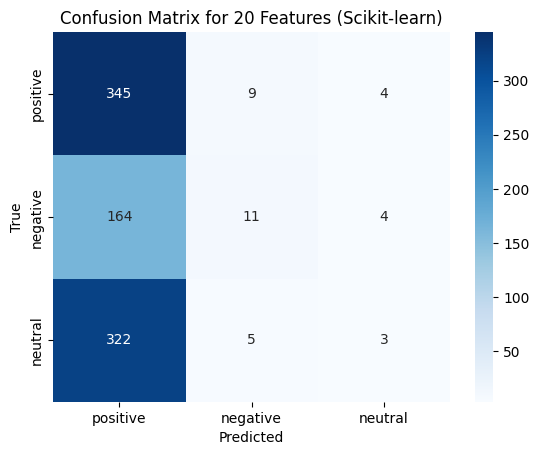

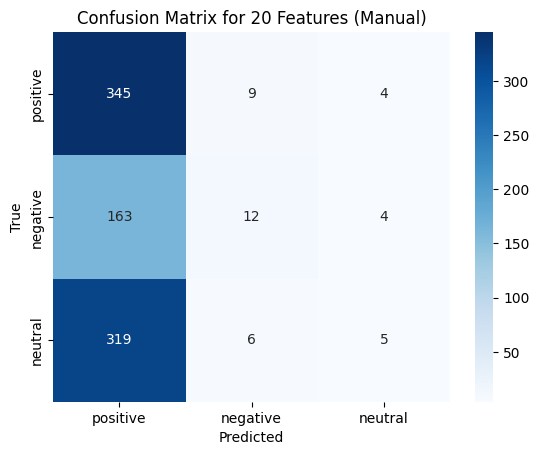

Evaluating model with 40 features...
Manual accuracy with 40 features: 0.4025
Scikit-learn accuracy with 40 features: 0.4025
K-Fold Cross Validation with k=3 for 40 features:
Accuracy for each fold: [0.52578797 0.53080229 0.53189964]
Precision for each fold: [0.40166882 0.4466724  0.29086772]
Recall for each fold: [0.3577023  0.37464485 0.26883402]
F1 Score for each fold: [0.3008485  0.34331249 0.23675159]
-------------------------------------------------------------
K-Fold Cross Validation with k=4 for 40 features:
Accuracy for each fold: [0.52340019 0.53963706 0.52626552 0.52868069]
Precision for each fold: [0.40702335 0.4371321  0.4534133  0.27405817]
Recall for each fold: [0.36087716 0.36270165 0.36836649 0.26398108]
F1 Score for each fold: [0.31005387 0.31748384 0.32519208 0.23340336]
-------------------------------------------------------------
K-Fold Cross Validation with k=5 for 40 features:
Accuracy for each fold: [0.51909308 0.54653938 0.50776583 0.52568698 0.53285544]
Precis

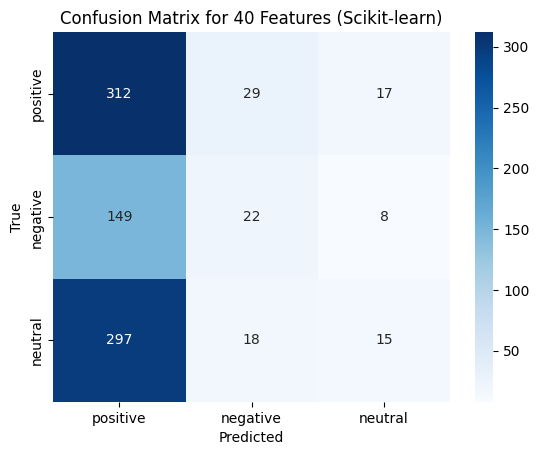

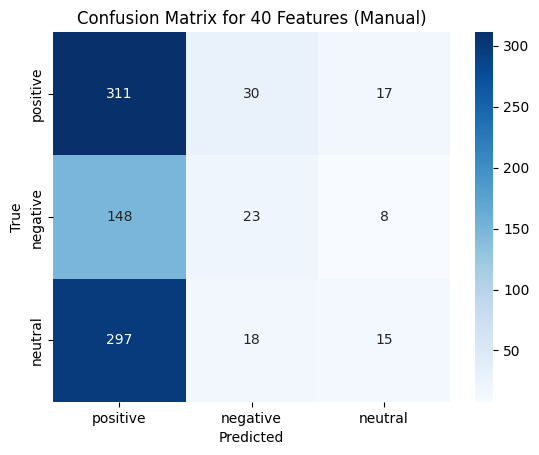

Evaluating model with 60 features...
Manual accuracy with 60 features: 0.4360
Scikit-learn accuracy with 60 features: 0.4348
K-Fold Cross Validation with k=3 for 60 features:
Accuracy for each fold: [0.53080229 0.53510029 0.54480287]
Precision for each fold: [0.44617811 0.45091392 0.32488119]
Recall for each fold: [0.38888692 0.40452124 0.30270055]
F1 Score for each fold: [0.36440878 0.39354042 0.29072341]
-------------------------------------------------------------
K-Fold Cross Validation with k=4 for 60 features:
Accuracy for each fold: [0.52244508 0.5339064  0.5339064  0.55162524]
Precision for each fold: [0.42828915 0.44016704 0.4346819  0.33383144]
Recall for each fold: [0.38573836 0.38995509 0.39817405 0.31191886]
F1 Score for each fold: [0.35861872 0.37585771 0.37578098 0.30402889]
-------------------------------------------------------------
K-Fold Cross Validation with k=5 for 60 features:
Accuracy for each fold: [0.51670644 0.5477327  0.51493429 0.54002389 0.54360812]
Precis

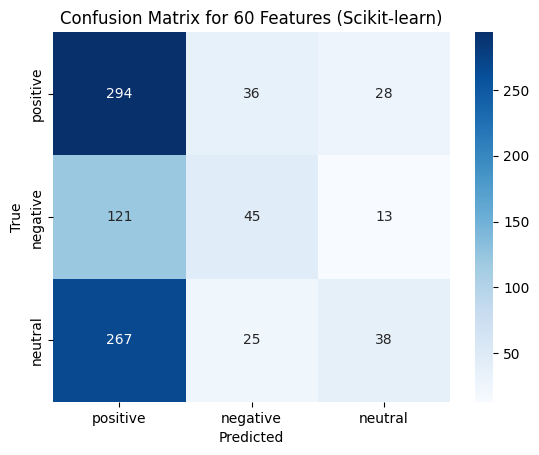

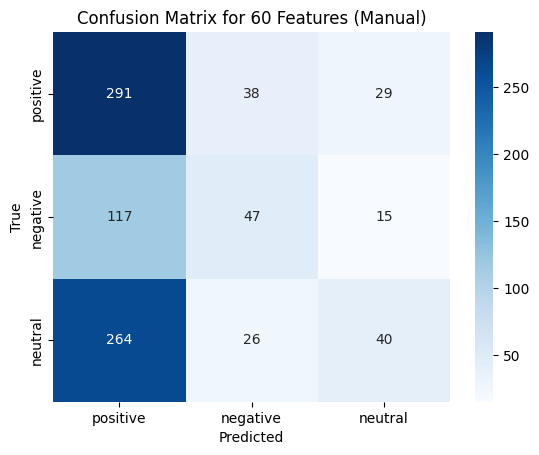

Evaluating model with 80 features...
Manual accuracy with 80 features: 0.4683
Scikit-learn accuracy with 80 features: 0.4683
K-Fold Cross Validation with k=3 for 80 features:
Accuracy for each fold: [0.53223496 0.5487106  0.55483871]
Precision for each fold: [0.45526622 0.48614837 0.35264394]
Recall for each fold: [0.40786583 0.44272952 0.32561724]
F1 Score for each fold: [0.39894198 0.44412834 0.32400562]
-------------------------------------------------------------
K-Fold Cross Validation with k=4 for 80 features:
Accuracy for each fold: [0.53963706 0.55109838 0.54918816 0.54971319]
Precision for each fold: [0.4676222  0.48386985 0.48375601 0.3407946 ]
Recall for each fold: [0.41920708 0.43284085 0.43852572 0.3216306 ]
F1 Score for each fold: [0.40932237 0.43559992 0.43543636 0.32031428]
-------------------------------------------------------------
K-Fold Cross Validation with k=5 for 80 features:
Accuracy for each fold: [0.54415274 0.54534606 0.52210275 0.55555556 0.55197133]
Precis

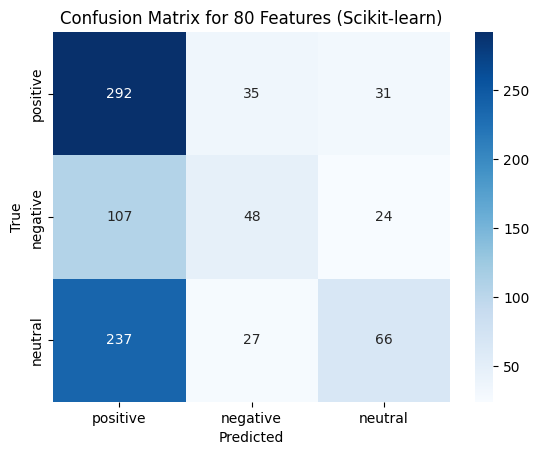

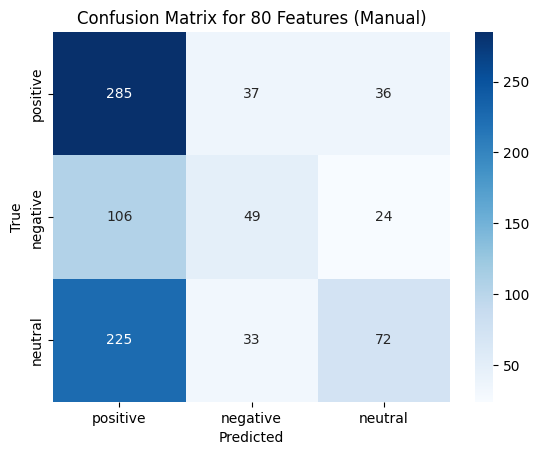

Evaluating model with 100 features...
Manual accuracy with 100 features: 0.4810
Scikit-learn accuracy with 100 features: 0.4729
K-Fold Cross Validation with k=3 for 100 features:
Accuracy for each fold: [0.52722063 0.54369628 0.56630824]
Precision for each fold: [0.44688277 0.48118658 0.36045898]
Recall for each fold: [0.41469559 0.44349309 0.33974839]
F1 Score for each fold: [0.41079688 0.4460197  0.33873033]
-------------------------------------------------------------
K-Fold Cross Validation with k=4 for 100 features:
Accuracy for each fold: [0.54059217 0.55396371 0.55682904 0.55640535]
Precision for each fold: [0.46978897 0.48288753 0.49730536 0.3483497 ]
Recall for each fold: [0.43129593 0.44217416 0.45507512 0.33317406]
F1 Score for each fold: [0.42661241 0.44609755 0.45657287 0.33341778]
-------------------------------------------------------------
K-Fold Cross Validation with k=5 for 100 features:
Accuracy for each fold: [0.53937947 0.55011933 0.53285544 0.5651135  0.5651135 ]


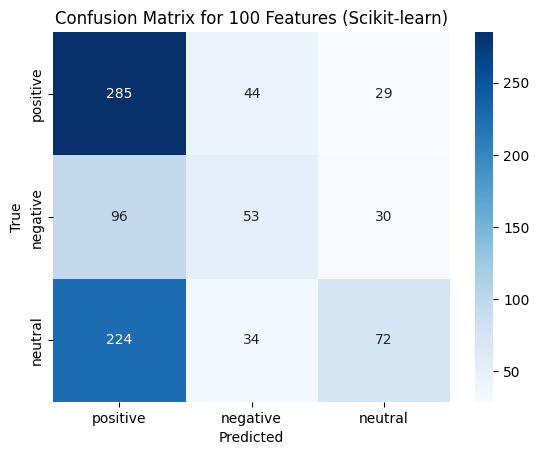

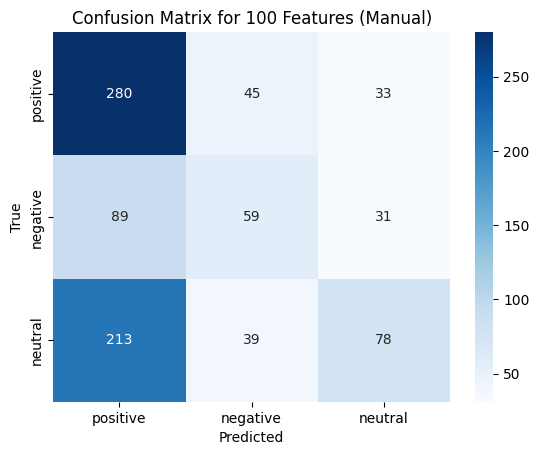

Evaluating model with 120 features...
Manual accuracy with 120 features: 0.5075
Scikit-learn accuracy with 120 features: 0.4890
K-Fold Cross Validation with k=3 for 120 features:
Accuracy for each fold: [0.53295129 0.55372493 0.55770609]
Precision for each fold: [0.45792685 0.49216229 0.35462258]
Recall for each fold: [0.42716042 0.45866021 0.3375977 ]
F1 Score for each fold: [0.42668762 0.46306431 0.33722846]
-------------------------------------------------------------
K-Fold Cross Validation with k=4 for 120 features:
Accuracy for each fold: [0.53199618 0.56255969 0.56542502 0.54780115]
Precision for each fold: [0.45545318 0.49555657 0.50535956 0.34344856]
Recall for each fold: [0.42729124 0.45849445 0.46695294 0.33153817]
F1 Score for each fold: [0.42398797 0.46438609 0.47040351 0.33214699]
-------------------------------------------------------------
K-Fold Cross Validation with k=5 for 120 features:
Accuracy for each fold: [0.54534606 0.55847255 0.53405018 0.56750299 0.55197133]


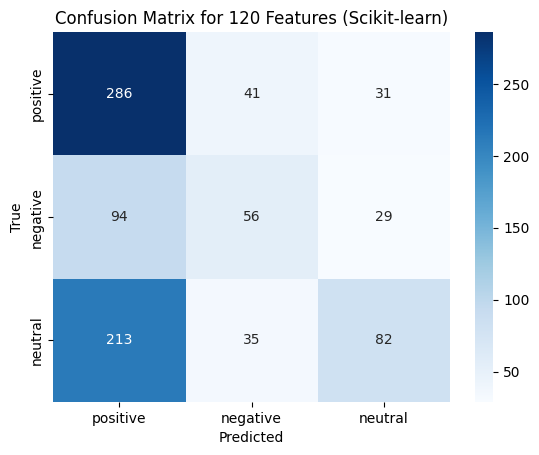

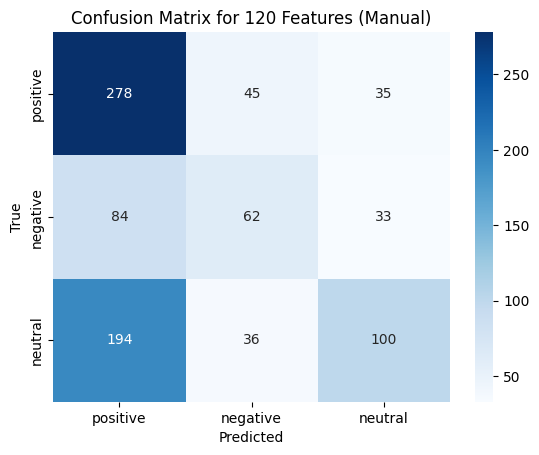

Evaluating model with 240 features...
Manual accuracy with 240 features: 0.5409
Scikit-learn accuracy with 240 features: 0.5271
K-Fold Cross Validation with k=3 for 240 features:
Accuracy for each fold: [0.5530086  0.56375358 0.57562724]
Precision for each fold: [0.48747197 0.49962879 0.37848296]
Recall for each fold: [0.46604904 0.48083216 0.37049488]
F1 Score for each fold: [0.47029793 0.48585644 0.37209425]
-------------------------------------------------------------
K-Fold Cross Validation with k=4 for 240 features:
Accuracy for each fold: [0.55969436 0.56542502 0.57975167 0.56596558]
Precision for each fold: [0.49626495 0.49885133 0.52343028 0.36876194]
Recall for each fold: [0.47864021 0.47476147 0.50211168 0.3631495 ]
F1 Score for each fold: [0.48175972 0.48064807 0.50767502 0.36483542]
-------------------------------------------------------------
K-Fold Cross Validation with k=5 for 240 features:
Accuracy for each fold: [0.57279236 0.57637232 0.54480287 0.58781362 0.57706093]


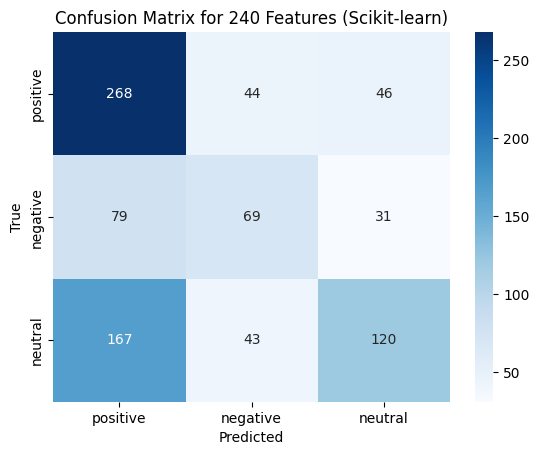

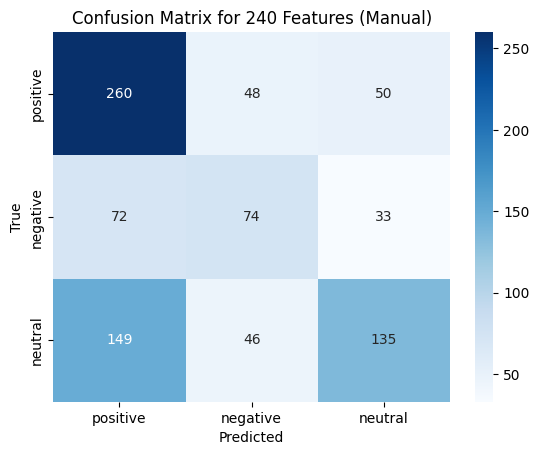

Evaluating model with 480 features...
Manual accuracy with 480 features: 0.5744
Scikit-learn accuracy with 480 features: 0.5548
K-Fold Cross Validation with k=3 for 480 features:
Accuracy for each fold: [0.56160458 0.59527221 0.590681  ]
Precision for each fold: [0.50707066 0.54532396 0.39520289]
Recall for each fold: [0.4889857  0.53530878 0.38984052]
F1 Score for each fold: [0.49442876 0.53813222 0.39135458]
-------------------------------------------------------------
K-Fold Cross Validation with k=4 for 480 features:
Accuracy for each fold: [0.57211079 0.58739255 0.58739255 0.60325048]
Precision for each fold: [0.51870193 0.5326441  0.53708272 0.4014481 ]
Recall for each fold: [0.50139484 0.51156814 0.53152004 0.39864681]
F1 Score for each fold: [0.50692901 0.51829069 0.53238332 0.39952789]
-------------------------------------------------------------
K-Fold Cross Validation with k=5 for 480 features:
Accuracy for each fold: [0.59188544 0.58591885 0.58422939 0.59617682 0.60812425]


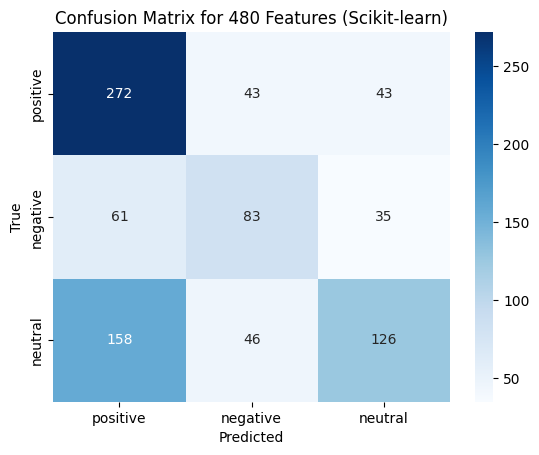

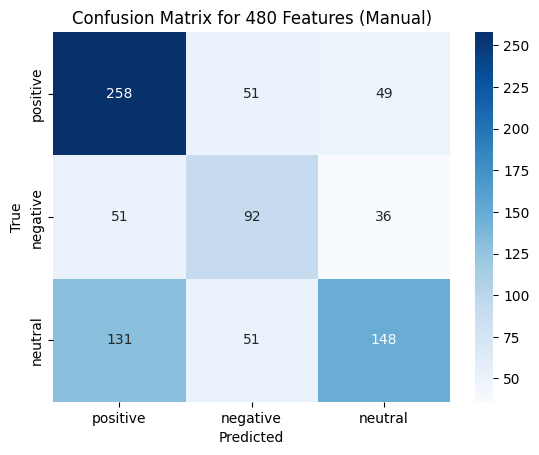

Evaluating model with 500 features...
Manual accuracy with 500 features: 0.5755
Scikit-learn accuracy with 500 features: 0.5582
K-Fold Cross Validation with k=3 for 500 features:
Accuracy for each fold: [0.56518625 0.6017192  0.59641577]
Precision for each fold: [0.50968184 0.55278558 0.40028402]
Recall for each fold: [0.49153457 0.54240092 0.39295376]
F1 Score for each fold: [0.49686801 0.54524658 0.39503572]
-------------------------------------------------------------
K-Fold Cross Validation with k=4 for 500 features:
Accuracy for each fold: [0.56924546 0.59025788 0.59503343 0.6042065 ]
Precision for each fold: [0.51495265 0.53468068 0.54387098 0.40321211]
Recall for each fold: [0.49958652 0.51421885 0.53605072 0.39860062]
F1 Score for each fold: [0.50463291 0.52090903 0.537634   0.40015223]
-------------------------------------------------------------
K-Fold Cross Validation with k=5 for 500 features:
Accuracy for each fold: [0.58472554 0.58949881 0.58781362 0.59498208 0.60573477]


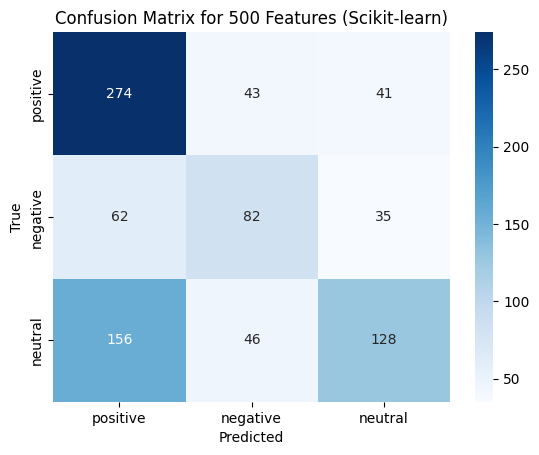

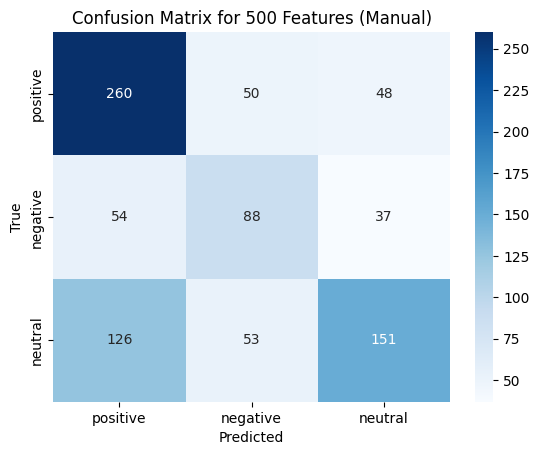

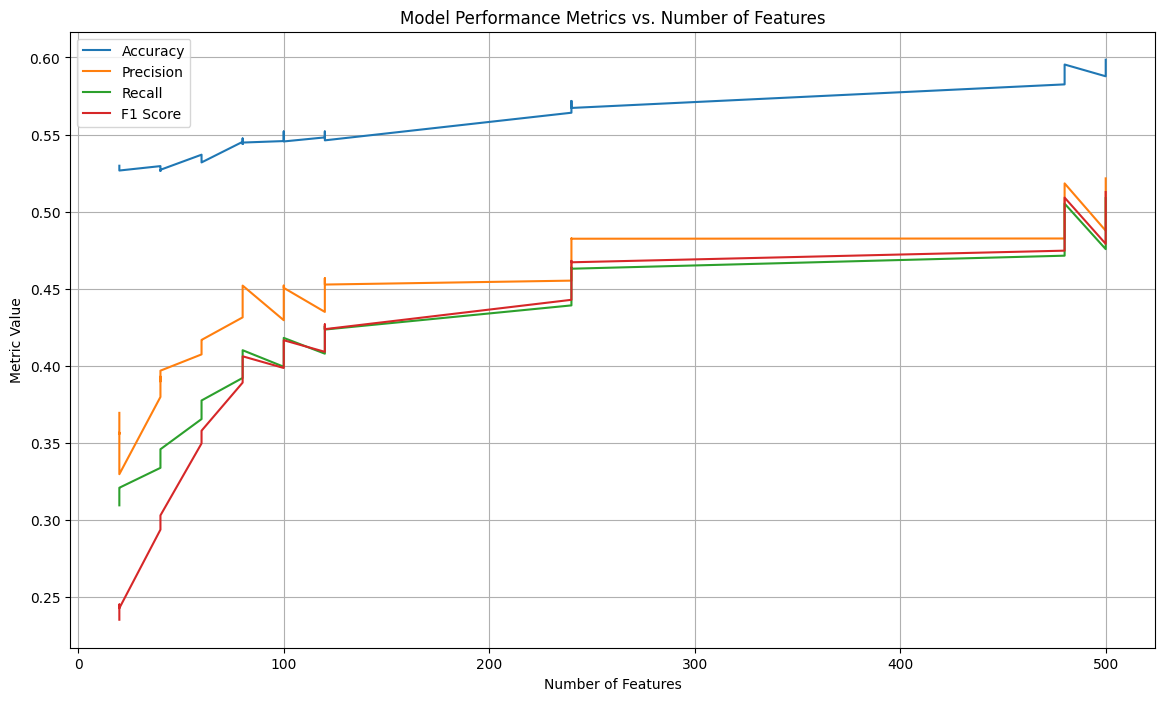

In [7]:
metrics_results = {
    'features': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
# Iterate through different feature numbers and evaluate the model
for featureNumber in feature_numbers:
    print(f"Evaluating model with {featureNumber} features...")
    trainingVectors, trainingLabels, testVectors, testLabels = prepare_data(featureNumber)

    # Train the Naive Bayes model
    model = naiveBayesTraining(trainingVectors, trainingLabels)
    naive_bayes = MultinomialNB()
    naive_bayes.fit(trainingVectors, trainingLabels)

    # Make predictions on the test data
    predictions = naive_bayes.predict(testVectors)

    # Classify test data and compute manual accuracy
    correctPredictions = 0
    totalPredictions = 0

    for vector, label in zip(testVectors, testLabels):
        totalPredictions += 1
        predictedLabel = classifyNB(vector, model[0], model[1], model[2], model[3], model[4], model[5])
        if predictedLabel == label:
            correctPredictions += 1

    manual_accuracy = correctPredictions / totalPredictions
    manual_predictions = [classifyNB(vector, model[0], model[1], model[2], model[3], model[4], model[5]) for vector in testVectors]

    scikit_accuracy = accuracy_score(testLabels, predictions)

    print(f"Manual accuracy with {featureNumber} features: {manual_accuracy:.4f}")
    print(f"Scikit-learn accuracy with {featureNumber} features: {scikit_accuracy:.4f}")

    # Perform K-Fold Cross Validation for each k value
    for k in k_values:
        kfold = KFold(n_splits=k, shuffle=True, random_state=42)
        scoring = {
            'accuracy': 'accuracy',
            'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
            'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
            'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
        }

        results = cross_validate(naive_bayes, trainingVectors, trainingLabels, cv=kfold, scoring=scoring, return_train_score=False)

        metrics_results['features'].append(featureNumber)
        metrics_results['accuracy'].append(results['test_accuracy'].mean())
        metrics_results['precision'].append(results['test_precision_macro'].mean())
        metrics_results['recall'].append(results['test_recall_macro'].mean())
        metrics_results['f1_score'].append(results['test_f1_macro'].mean())

        print(f"K-Fold Cross Validation with k={k} for {featureNumber} features:")
        print(f"Accuracy for each fold: {results['test_accuracy']}")
        print(f"Precision for each fold: {results['test_precision_macro']}")
        print(f"Recall for each fold: {results['test_recall_macro']}")
        print(f"F1 Score for each fold: {results['test_f1_macro']}")
        print("-------------------------------------------------------------")

    # Confusion Matrix Plot for Scikit Learn Implementation
    cm = confusion_matrix(testLabels, predictions, labels=["positive", "negative", "neutral"])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["positive", "negative", "neutral"], yticklabels=["positive", "negative", "neutral"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {featureNumber} Features (Scikit-learn)')
    plt.show()

    # Confusion Matrix Plot for Manual Implementation
    cm_manual = confusion_matrix(testLabels, manual_predictions, labels=["positive", "negative", "neutral"])
    sns.heatmap(cm_manual, annot=True, fmt='d', cmap='Blues', xticklabels=["positive", "negative", "neutral"], yticklabels=["positive", "negative", "neutral"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {featureNumber} Features (Manual)')
    plt.show()

df_metrics = pd.DataFrame(metrics_results)
plt.figure(figsize=(14, 8))

plt.plot(df_metrics['features'], df_metrics['accuracy'], label='Accuracy')
plt.plot(df_metrics['features'], df_metrics['precision'], label='Precision')
plt.plot(df_metrics['features'], df_metrics['recall'], label='Recall')
plt.plot(df_metrics['features'], df_metrics['f1_score'], label='F1 Score')

plt.title('Model Performance Metrics vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

## Conclusiones

Los resultados obtenidos durante la evaluación de los modelos de clasificación Naive Bayes muestran una disparidad interesante entre el modelo implementado manualmente y el modelo de Scikit-learn.

Sorprendentemente, el modelo Naive Bayes implementado manualmente mostró una mayor eficacia en comparación con el modelo de Scikit-learn. Este hallazgo podría parecer inesperado, especialmente dado que Scikit-learn es una biblioteca ampliamente utilizada y probada en la práctica. La diferencia en la eficacia se debe en parte a la falta de ajuste de hiperparámetros en la implementación de Scikit-learn. Scikit-learn, como cualquier otro modelo de machine learning, puede beneficiarse significativamente del ajuste de hiperparámetros para mejorar su rendimiento. Sin embargo, en esta evaluación, se utilizaron los parámetros predeterminados, lo que puede no ser óptimo para todos los conjuntos de datos.

Un factor crucial que afectó tanto el rendimiento del modelo de Scikit-learn y la implementación manual, fue el desbalanceo en los datos de entrenamiento. En el conjunto de datos utilizado, algunas etiquetas estaban significativamente menos representadas que otras. Este desbalanceo se traduce en problemas durante el cálculo de métricas de rendimiento como la "Accuracy". En particular, algunos vectores de prueba no fueron clasificados en ninguna etiqueta, lo que sugiere que el modelo no logró generalizar bien debido a la prevalencia desigual de las etiquetas en el conjunto de entrenamiento.